#**Otimização Avançada em Deep Learning com PyTorch: Uma Análisem Aplicada ao Fashion-MNIST**

## Discentes: Júlia Alanne Silvino dos Santos, Pablo Durkheim Fernandes do Nascimento

---



# **EWMA Meets Gradients e visualização de gradientes**

--- 2. Preparação dos Dados (Fashion-MNIST) ---
DataLoaders configurados. Passos por época: 938

--- Treinando com SGD Simples por 30 Épocas ---
Starting training on cpu for 30 epochs...
Epoch 1/30 - Loss: 1.0177 - Val Loss: 0.7229 - Acc: 0.7361 - Val Acc: 0.7252 - LR: 0.010000
Epoch 2/30 - Loss: 0.6717 - Val Loss: 0.6484 - Acc: 0.7637 - Val Acc: 0.7534 - LR: 0.010000
Epoch 3/30 - Loss: 0.6234 - Val Loss: 0.6797 - Acc: 0.7555 - Val Acc: 0.7447 - LR: 0.010000
Epoch 4/30 - Loss: 0.5978 - Val Loss: 0.6317 - Acc: 0.7719 - Val Acc: 0.7599 - LR: 0.010000
Epoch 5/30 - Loss: 0.5820 - Val Loss: 0.6188 - Acc: 0.7802 - Val Acc: 0.7682 - LR: 0.010000
Epoch 6/30 - Loss: 0.5721 - Val Loss: 0.5763 - Acc: 0.7968 - Val Acc: 0.7817 - LR: 0.010000
Epoch 7/30 - Loss: 0.5528 - Val Loss: 0.6215 - Acc: 0.7853 - Val Acc: 0.7675 - LR: 0.010000
Epoch 8/30 - Loss: 0.5541 - Val Loss: 0.5739 - Acc: 0.7932 - Val Acc: 0.7819 - LR: 0.010000
Epoch 9/30 - Loss: 0.5374 - Val Loss: 0.6235 - Acc: 0.7800 - Val Acc: 0.7688 

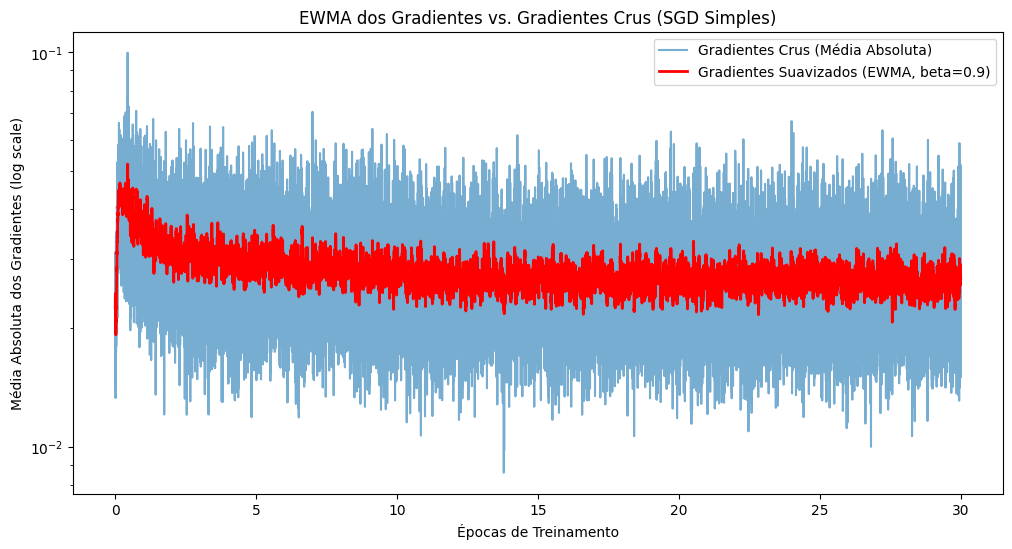


--- Visualização das Métricas (Loss e Accuracy) SGD Simples ---


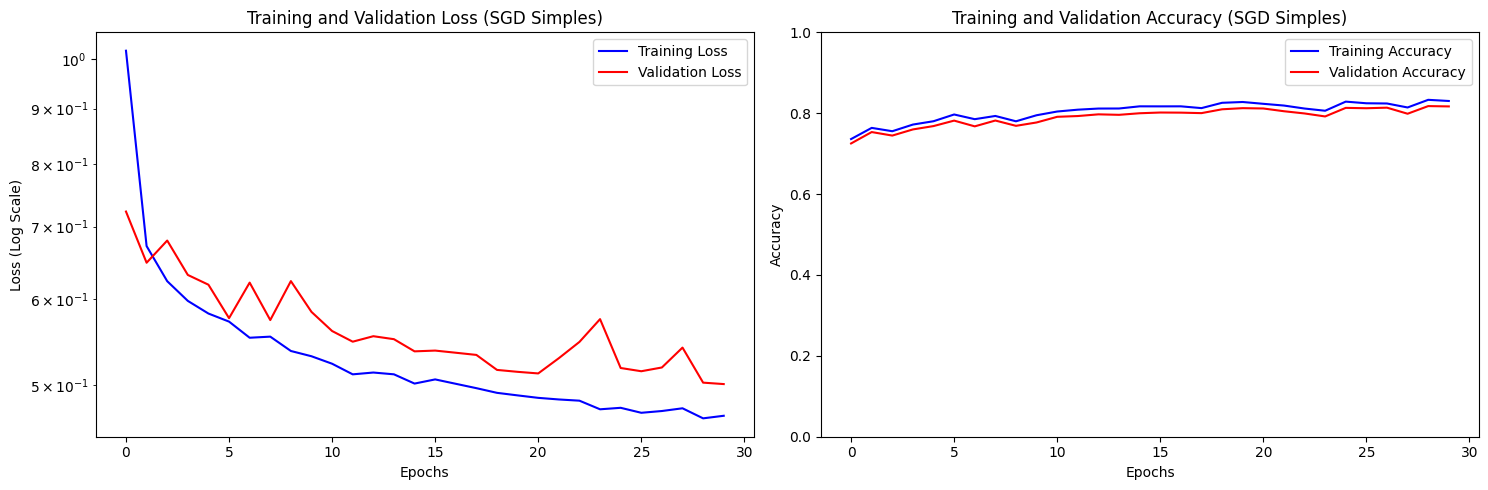

In [ ]:
# ==============================================================================
# 0. Configuração e Imports
# ==============================================================================
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
from IPython.display import display

# Definições
N_EPOCHS = 30  # Rodando por 10 épocas para a demonstração inicial
SEED = 42

# Função Auxiliar para EWMA
def ewma(data, alpha):
    """Calcula a Média Móvel Exponencialmente Ponderada (EWMA)."""
    ewma_data = [data[0]] if data else []
    for i in range(1, len(data)):
        ewma_data.append(alpha * data[i] + (1 - alpha) * ewma_data[-1])
    return ewma_data

# ==============================================================================
# 1. Classe Architecture Aprimorada (Com Coleta de Gradientes)
# ==============================================================================

class Architecture(object):
    """
    Classe aprimorada para encapsular arquitetura e treinamento,
    incluindo coleta de gradientes e Learning Rate.
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.total_epochs = 0
        self.all_grads = []
        self.learning_rates = []
        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()
        self.steps_per_epoch = 0

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        if train_loader:
             self.steps_per_epoch = len(train_loader)

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)

            self.optimizer.zero_grad()
            loss.backward()

            # Coleta de Gradientes Crus (Média Absoluta por mini-batch)
            avg_abs_grad = 0.0
            num_params = 0
            for param in self.model.parameters():
                if param.grad is not None:
                    # Registra a média do valor absoluto do gradiente
                    avg_abs_grad += torch.abs(param.grad.detach()).mean().item()
                    num_params += 1

            if num_params > 0:
                 self.all_grads.append(avg_abs_grad / num_params)

            self.optimizer.step()

            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        data_loader = self.val_loader if validation else self.train_loader
        step_fn = self.val_step_fn if validation else self.train_step_fn
        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def _calculate_accuracy(self, data_loader):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            with torch.no_grad():
                yhat = self.model(x_batch)
                predicted = torch.argmax(yhat, dim=1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)
        return total_correct / total_samples

    def set_seed(self, seed=SEED):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def train(self, n_epochs, scheduler=None):
        self.set_seed(SEED)
        self.total_epochs = 0
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.all_grads = []
        self.learning_rates = []

        print(f"Starting training on {self.device} for {n_epochs} epochs...")
        for epoch in range(n_epochs):
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # Armazena o learning rate atual
            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)

            # Validação
            with torch.no_grad():
                 val_loss = self._mini_batch(validation=True)
                 self.val_losses.append(val_loss)

            # Passo do scheduler (Não usamos nesta etapa, mas mantemos o código base)
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_loss)
                else:
                    scheduler.step()

            accuracy = self._calculate_accuracy(self.train_loader)
            self.accuracies.append(accuracy)
            val_accuracy = self._calculate_accuracy(self.val_loader)
            self.val_accuracies.append(val_accuracy)

            print(f"Epoch {self.total_epochs}/{n_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {accuracy:.4f} - Val Acc: {val_accuracy:.4f} - LR: {current_lr:.6f}")
        print("Training finished.")

    def plot_metrics(self, title_suffix=""):
        """Plota Loss e Accuracy."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ax1.plot(self.losses, label='Training Loss', c='b')
        ax1.plot(self.val_losses, label='Validation Loss', c='r')
        ax1.set_yscale('log')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss (Log Scale)')
        ax1.set_title(f'Training and Validation Loss {title_suffix}')
        ax1.legend()

        ax2.plot(self.accuracies, label='Training Accuracy', c='b')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', c='r')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'Training and Validation Accuracy {title_suffix}')
        ax2.set_ylim(0, 1)
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_gradients(self, alpha=0.1, title="EWMA dos Gradientes vs. Gradientes Crus"):
        """Plota a média absoluta dos gradientes brutos e suavizados (EWMA)."""
        if not self.all_grads:
             print("Nenhum gradiente coletado.")
             return None

        ewma_g = ewma(self.all_grads, alpha)

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        steps = np.arange(len(self.all_grads)) / self.steps_per_epoch

        ax.plot(steps, self.all_grads, label='Gradientes Crus (Média Absoluta)', alpha=0.6)

        # O parâmetro do EWMA é beta. Se alpha=0.1, beta=0.9, que é o valor típico de momentum.
        ax.plot(steps, ewma_g, label=f'Gradientes Suavizados (EWMA, beta={1-alpha:.1f})', linewidth=2, c='red')

        ax.set_xlabel('Épocas de Treinamento')
        ax.set_ylabel('Média Absoluta dos Gradientes (log scale)')
        ax.set_yscale('log')
        ax.set_title(title)
        ax.legend()
        plt.show()

# Funções auxiliares adicionais (para dataset)
def make_balanced_sampler(y):
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# Função para criar o modelo CNN (reutilizada da Unidade 2)
def create_new_cnn_model(input_size=144, output_classes=10):
    n_channels = 1
    INPUT_SIZE = input_size
    OUTPUT_CLASSES = output_classes

    torch.manual_seed(17)
    model_cnn = nn.Sequential()

    # Featurizer (baseado na arquitetura LeNet-like da Unidade 2)
    model_cnn.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=5))
    model_cnn.add_module('relu1', nn.ReLU())
    model_cnn.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
    model_cnn.add_module('flatten', nn.Flatten())

    # Classifier
    model_cnn.add_module('fc1', nn.Linear(in_features=INPUT_SIZE, out_features=10))
    model_cnn.add_module('relu2', nn.ReLU())
    model_cnn.add_module('fc2', nn.Linear(in_features=10, out_features=OUTPUT_CLASSES))

    return model_cnn.to('cuda' if torch.cuda.is_available() else 'cpu')


# ==============================================================================
# 2. Preparação do Dataset e DataLoaders
# ==============================================================================
print("--- 2. Preparação dos Dados (Fashion-MNIST) ---")
FASHION_MNIST_MEAN = (0.5,)
FASHION_MNIST_STD = (0.5,)
IMG_SIZE = 28
BATCH_SIZE = 64

train_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
val_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
full_train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transforms)
full_val_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=val_transforms)
y_train_tensor = full_train_dataset.targets
sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(dataset=full_train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=full_val_dataset, batch_size=BATCH_SIZE)
print(f"DataLoaders configurados. Passos por época: {len(train_loader)}")

# ==============================================================================
# 3. Experimento SGD Simples (10 Épocas) - Tópico 1/3 Baseline
# ==============================================================================
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# SGD Simples
model_sgd = create_new_cnn_model()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
arch_sgd = Architecture(model_sgd, multi_loss_fn, optimizer_sgd)
arch_sgd.set_loaders(train_loader, val_loader)

print(f"\n--- Treinando com SGD Simples por {N_EPOCHS} Épocas ---")
arch_sgd.train(N_EPOCHS)

# ==============================================================================
# 4. Visualização e Análise (Tópico 1/3)
# Esta é a última etapa da Parte 1 (Gráficos Reais)
# ==============================================================================
print("\n--- Visualização da Suavização de Gradientes (EWMA) SGD Simples ---")
arch_sgd.plot_gradients(alpha=0.1, title="EWMA dos Gradientes vs. Gradientes Crus (SGD Simples)")

print("\n--- Visualização das Métricas (Loss e Accuracy) SGD Simples ---")
arch_sgd.plot_metrics(title_suffix="(SGD Simples)")

# **Adam, SGD e sua variantes, visualização de gradientes adapatados**

--- 2. Preparação dos Dados (Fashion-MNIST) ---
DataLoaders configurados. Passos por época: 938

--- Treinando com SGD_Simple por 10 Épocas ---
Starting training on cpu for 10 epochs...


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch 1/10 - Loss: 1.0177 - Val Loss: 0.7229 - Acc: 0.7361 - Val Acc: 0.7252 - LR: 0.010000
Epoch 2/10 - Loss: 0.6717 - Val Loss: 0.6484 - Acc: 0.7637 - Val Acc: 0.7534 - LR: 0.010000
Epoch 3/10 - Loss: 0.6234 - Val Loss: 0.6797 - Acc: 0.7555 - Val Acc: 0.7447 - LR: 0.010000
Epoch 4/10 - Loss: 0.5978 - Val Loss: 0.6317 - Acc: 0.7719 - Val Acc: 0.7599 - LR: 0.010000
Epoch 5/10 - Loss: 0.5820 - Val Loss: 0.6188 - Acc: 0.7802 - Val Acc: 0.7682 - LR: 0.010000
Epoch 6/10 - Loss: 0.5721 - Val Loss: 0.5763 - Acc: 0.7968 - Val Acc: 0.7817 - LR: 0.010000
Epoch 7/10 - Loss: 0.5528 - Val Loss: 0.6215 - Acc: 0.7853 - Val Acc: 0.7675 - LR: 0.010000
Epoch 8/10 - Loss: 0.5541 - Val Loss: 0.5739 - Acc: 0.7932 - Val Acc: 0.7819 - LR: 0.010000
Epoch 9/10 - Loss: 0.5374 - Val Loss: 0.6235 - Acc: 0.7800 - Val Acc: 0.7688 - LR: 0.010000
Epoch 10/10 - Loss: 0.5314 - Val Loss: 0.5840 - Acc: 0.7950 - Val Acc: 0.7771 - LR: 0.010000
Training finished.

--- Treinando com SGD_Momentum_0.9 por 10 Épocas ---
Starti

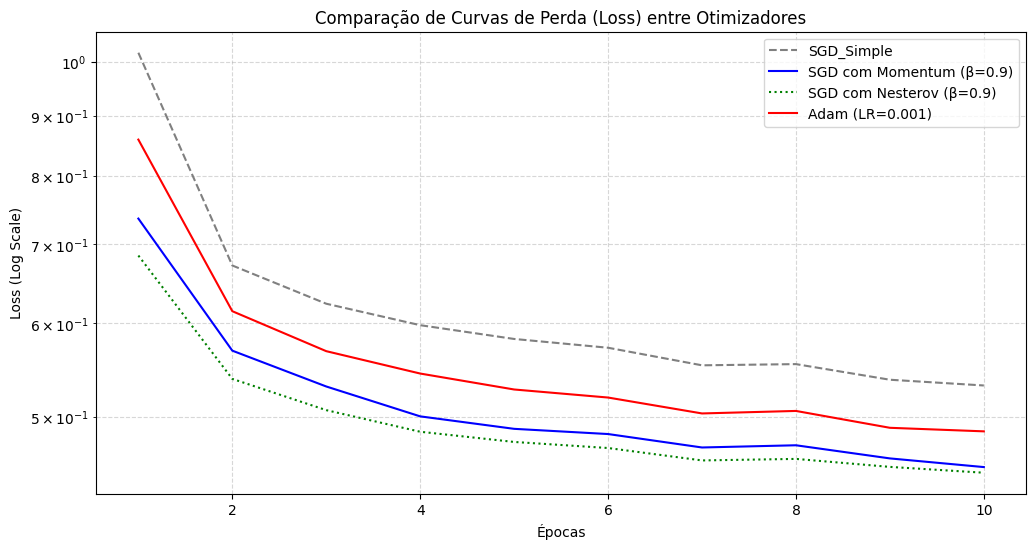

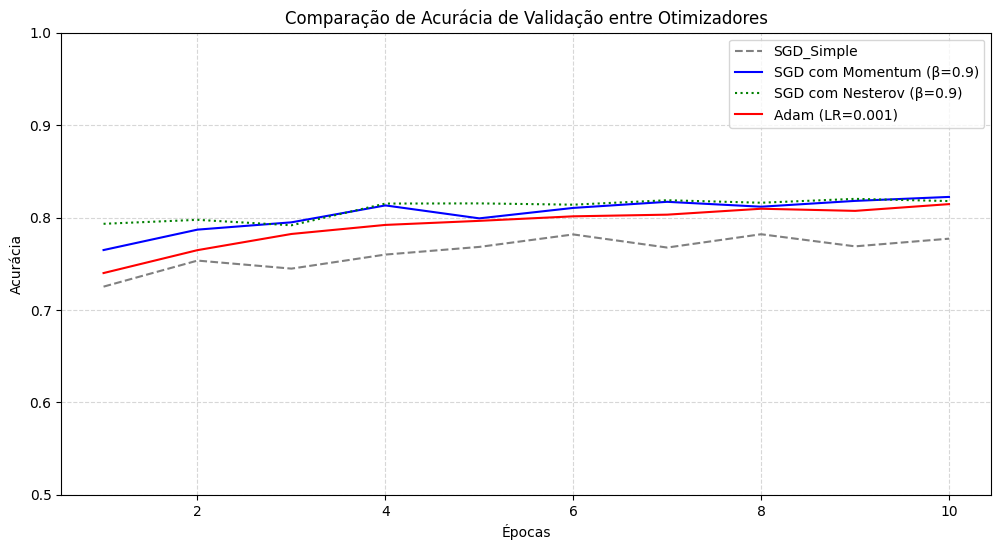


--- GRÁFICOS DE GRADIENTES ADAPTADOS (TÓPICO 3) ---


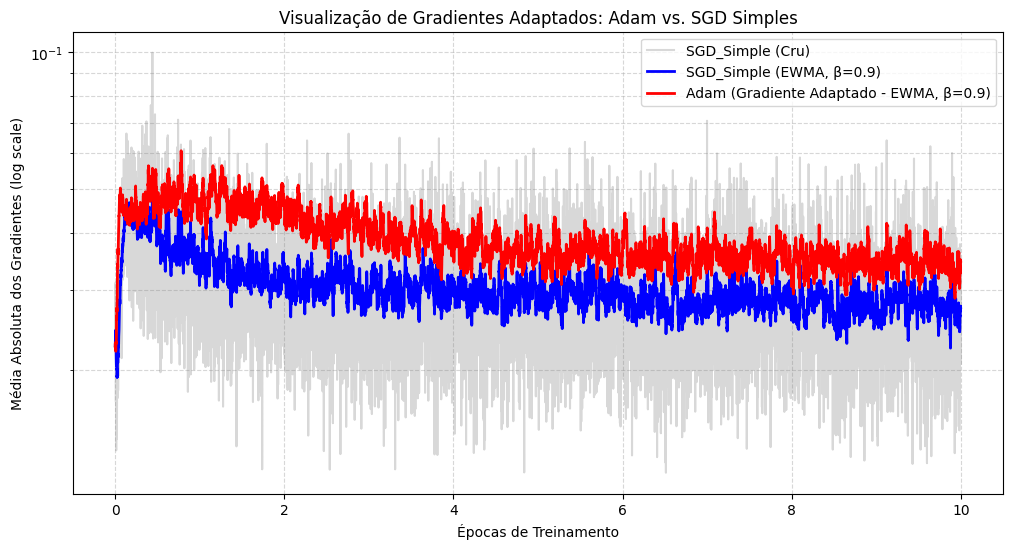

In [ ]:
# ==============================================================================
# 0. Configuração e Imports
# ==============================================================================
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import pandas as pd

# Definições adaptadas para 10 ÉPOCAS
N_EPOCHS = 10
LR_SGD = 0.01
LR_ADAM = 0.001
SEED = 42

# Função Auxiliar para EWMA (necessária para plotar gradientes)
def ewma(data, alpha):
    """Calcula a Média Móvel Exponencialmente Ponderada (EWMA)."""
    ewma_data = [data[0]] if data else []
    for i in range(1, len(data)):
        ewma_data.append(alpha * data[i] + (1 - alpha) * ewma_data[-1])
    return ewma_data

# ==============================================================================
# 1. Classe Architecture Aprimorada (Com Coleta de Gradientes)
# ==============================================================================

class Architecture(object):
    """
    Classe aprimorada para encapsular arquitetura e treinamento,
    incluindo coleta da média absoluta de gradientes e Learning Rate por epoch.
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.total_epochs = 0
        self.all_grads = []
        self.learning_rates = []
        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()
        self.steps_per_epoch = 0

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        if train_loader:
             self.steps_per_epoch = len(train_loader)

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)

            self.optimizer.zero_grad()
            loss.backward()

            # Coleta de Gradientes Crus (Média Absoluta por mini-batch)
            avg_abs_grad = 0.0
            num_params = 0
            for param in self.model.parameters():
                if param.grad is not None:
                    # Registra a média do valor absoluto do gradiente
                    avg_abs_grad += torch.abs(param.grad.detach()).mean().item()
                    num_params += 1

            if num_params > 0:
                 self.all_grads.append(avg_abs_grad / num_params)

            self.optimizer.step()

            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        data_loader = self.val_loader if validation else self.train_loader
        step_fn = self.val_step_fn if validation else self.train_step_fn
        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def _calculate_accuracy(self, data_loader):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            with torch.no_grad():
                yhat = self.model(x_batch)
                predicted = torch.argmax(yhat, dim=1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)
        return total_correct / total_samples

    def set_seed(self, seed=SEED):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def train(self, n_epochs, scheduler=None):
        self.set_seed(SEED)
        self.total_epochs = 0
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.all_grads = []
        self.learning_rates = []

        print(f"Starting training on {self.device} for {n_epochs} epochs...")
        for epoch in range(n_epochs):
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)

            with torch.no_grad():
                 val_loss = self._mini_batch(validation=True)
                 self.val_losses.append(val_loss)

            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_loss)
                else:
                    scheduler.step()

            accuracy = self._calculate_accuracy(self.train_loader)
            self.accuracies.append(accuracy)
            val_accuracy = self._calculate_accuracy(self.val_loader)
            self.val_accuracies.append(val_accuracy)

            print(f"Epoch {self.total_epochs}/{n_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {accuracy:.4f} - Val Acc: {val_accuracy:.4f} - LR: {current_lr:.6f}")
        print("Training finished.")

# Funções auxiliares adicionais (para dataset)
def make_balanced_sampler(y):
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# Função para criar o modelo CNN (reutilizada da Unidade 2)
def create_new_cnn_model(input_size=144, output_classes=10):
    n_channels = 1
    INPUT_SIZE = input_size
    OUTPUT_CLASSES = output_classes

    torch.manual_seed(17)
    model_cnn = nn.Sequential()

    # Arquitetura LeNet-like (Unidade 2)
    model_cnn.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=5))
    model_cnn.add_module('relu1', nn.ReLU())
    model_cnn.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
    model_cnn.add_module('flatten', nn.Flatten())

    model_cnn.add_module('fc1', nn.Linear(in_features=INPUT_SIZE, out_features=10))
    model_cnn.add_module('relu2', nn.ReLU())
    model_cnn.add_module('fc2', nn.Linear(in_features=10, out_features=OUTPUT_CLASSES))

    return model_cnn.to('cuda' if torch.cuda.is_available() else 'cpu')


# ==============================================================================
# 2. Preparação do Dataset e DataLoaders (Fashion-MNIST)
# ==============================================================================
print("--- 2. Preparação dos Dados (Fashion-MNIST) ---")
FASHION_MNIST_MEAN = (0.5,)
FASHION_MNIST_STD = (0.5,)
IMG_SIZE = 28
BATCH_SIZE = 64

train_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
val_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
full_train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transforms)
full_val_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=val_transforms)
y_train_tensor = full_train_dataset.targets
sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(dataset=full_train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=full_val_dataset, batch_size=BATCH_SIZE)
print(f"DataLoaders configurados. Passos por época: {len(train_loader)}")

# ==============================================================================
# 3. Experimentos de Otimização (SGD Simples, Momentum, Nesterov, Adam)
# ==============================================================================
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
results = {}

# Lista de otimizadores para iteração
optimizers_config = [
    ("SGD_Simple", LR_SGD, None, False),
    ("SGD_Momentum_0.9", LR_SGD, 0.9, False),
    ("SGD_Nesterov_0.9", LR_SGD, 0.9, True),
    ("Adam", LR_ADAM, (0.9, 0.999), 1e-8)
]

for name, lr, momentum, nesterov in optimizers_config:
    model = create_new_cnn_model()

    if name == "Adam":
         optimizer = optim.Adam(model.parameters(), lr=lr, betas=momentum, eps=nesterov)
    elif "SGD" in name:
         optimizer = optim.SGD(model.parameters(), lr=lr,
                               momentum=(momentum if momentum else 0),
                               nesterov=nesterov)

    arch = Architecture(model, multi_loss_fn, optimizer)
    arch.set_loaders(train_loader, val_loader)
    print(f"\n--- Treinando com {name} por {N_EPOCHS} Épocas ---")
    arch.train(N_EPOCHS)

    results[name] = {
        'losses': arch.losses, 'val_losses': arch.val_losses,
        'accuracies': arch.accuracies, 'val_accuracies': arch.val_accuracies,
        'grads': arch.all_grads, 'lr': arch.learning_rates,
        'steps_per_epoch': arch.steps_per_epoch
    }

# ==============================================================================
# 4. Funções de Plotagem Comparativa
# ==============================================================================

def plot_optimizer_metrics_comparison(metric_key, title, y_label, y_scale='linear', y_lim=None):
    """Gera o gráfico comparativo de Loss ou Accuracy (Tópico 2 e 4)."""
    plt.figure(figsize=(12, 6))

    # As chaves são 'SGD_Loss', 'Adam_Loss', etc.
    keys = {
        'SGD_Simple': 'SGD_Simple',
        'SGD_Momentum_0.9': 'SGD com Momentum (β=0.9)',
        'SGD_Nesterov_0.9': 'SGD com Nesterov (β=0.9)',
        'Adam': 'Adam (LR=0.001)'
    }

    styles = {
        'SGD_Simple': ('--', 'gray'),
        'SGD_Momentum_0.9': ('-', 'blue'),
        'SGD_Nesterov_0.9': (':', 'green'),
        'Adam': ('-', 'red')
    }

    for name in keys:
        data = results[name][metric_key]
        style, color = styles[name]
        plt.plot(range(1, N_EPOCHS + 1), data, label=keys[name], linestyle=style, color=color)

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel(y_label)
    plt.yscale(y_scale)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

def plot_gradients_comparison(optimizer_name, compare_name, title, alpha=0.1):
    """Gera o gráfico de Gradientes Adaptados vs. Gradientes Suavizados (Tópico 3)."""

    grads_opt = results[optimizer_name]['grads']
    grads_comp = results[compare_name]['grads']
    steps_per_epoch = results[optimizer_name]['steps_per_epoch']

    steps = np.arange(len(grads_opt)) / steps_per_epoch

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Gradientes Crus do SGD Simples (para referência)
    ax.plot(steps, grads_comp, label=f'{compare_name} (Cru)', alpha=0.3, c='gray')

    # Gradientes Suavizados (EWMA) do otimizador base (SGD Simples)
    # EWMA aplicada ao SGD Simples simula o Momentum
    ax.plot(steps, ewma(grads_comp, alpha), label=f'{compare_name} (EWMA, β={1-alpha:.1f})', linewidth=2, c='blue')

    # Gradientes Adaptados (EWMA) do Adam
    # A EWMA do Adam representa a média do primeiro momento (v), que é o gradiente adaptado.
    ax.plot(steps, ewma(grads_opt, alpha), label=f'{optimizer_name} (Gradiente Adaptado - EWMA, β={1-alpha:.1f})', linewidth=2, c='red')

    ax.set_xlabel('Épocas de Treinamento')
    ax.set_ylabel('Média Absoluta dos Gradientes (log scale)')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()


# ==============================================================================
# 5. Geração dos Gráficos Finais (Tópicos 2, 3 e 4)
# ==============================================================================

print("\n--- GRÁFICOS COMPARATIVOS (TÓPICOS 2 E 4) ---")
# Loss Comparativa
plot_optimizer_metrics_comparison(
    metric_key='losses',
    title='Comparação de Curvas de Perda (Loss) entre Otimizadores',
    y_label='Loss (Log Scale)',
    y_scale='log'
)
# Acurácia Comparativa
plot_optimizer_metrics_comparison(
    metric_key='val_accuracies',
    title='Comparação de Acurácia de Validação entre Otimizadores',
    y_label='Acurácia',
    y_lim=(0.5, 1.0)
)

print("\n--- GRÁFICOS DE GRADIENTES ADAPTADOS (TÓPICO 3) ---")
# Adam vs. SGD Gradientes
plot_gradients_comparison(
    optimizer_name='Adam',
    compare_name='SGD_Simple',
    title='Visualização de Gradientes Adaptados: Adam vs. SGD Simples'
)

LR

<>:370: SyntaxWarning: invalid escape sequence '\g'
<>:370: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1146317677.py:370: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(df_metrics['Epoch'], df_metrics['Adam_StepLR_Evol'], label='Adam + StepLR (step=5, $\gamma$=0.1)', linestyle='-', color='blue')


--- 2. Preparação dos Dados (Fashion-MNIST) ---
DataLoaders configurados. Passos por época: 938

--- Treinando com SGD_Simple ---
Starting training on cpu for 10 epochs...
Epoch 1/10 - Loss: 1.0177 - Val Loss: 0.7229 - Acc: 0.7361 - Val Acc: 0.7252 - LR: 0.010000
Epoch 2/10 - Loss: 0.6717 - Val Loss: 0.6484 - Acc: 0.7637 - Val Acc: 0.7534 - LR: 0.010000
Epoch 3/10 - Loss: 0.6234 - Val Loss: 0.6797 - Acc: 0.7555 - Val Acc: 0.7447 - LR: 0.010000
Epoch 4/10 - Loss: 0.5978 - Val Loss: 0.6317 - Acc: 0.7719 - Val Acc: 0.7599 - LR: 0.010000
Epoch 5/10 - Loss: 0.5820 - Val Loss: 0.6188 - Acc: 0.7802 - Val Acc: 0.7682 - LR: 0.010000
Epoch 6/10 - Loss: 0.5721 - Val Loss: 0.5763 - Acc: 0.7968 - Val Acc: 0.7817 - LR: 0.010000
Epoch 7/10 - Loss: 0.5528 - Val Loss: 0.6215 - Acc: 0.7853 - Val Acc: 0.7675 - LR: 0.010000
Epoch 8/10 - Loss: 0.5541 - Val Loss: 0.5739 - Acc: 0.7932 - Val Acc: 0.7819 - LR: 0.010000
Epoch 9/10 - Loss: 0.5374 - Val Loss: 0.6235 - Acc: 0.7800 - Val Acc: 0.7688 - LR: 0.010000


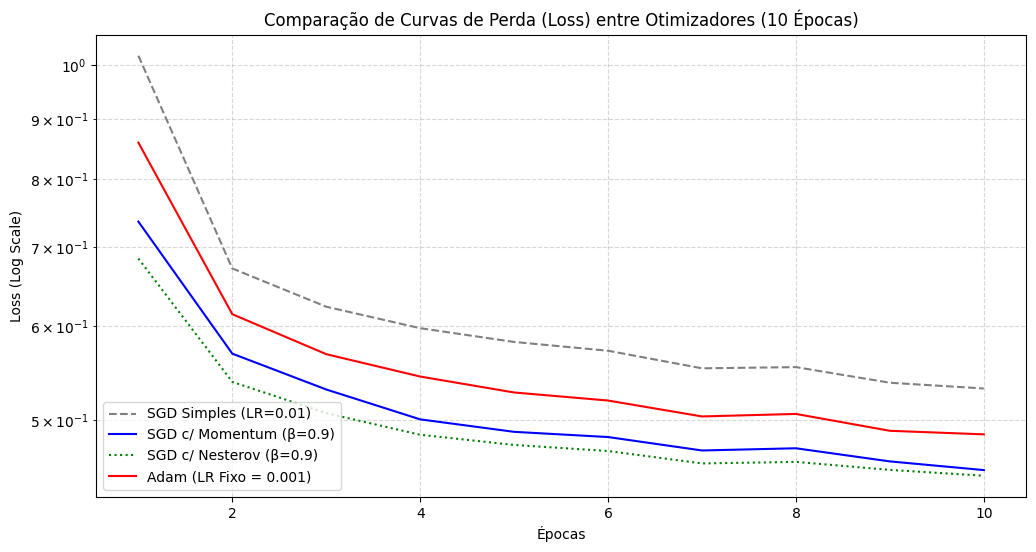

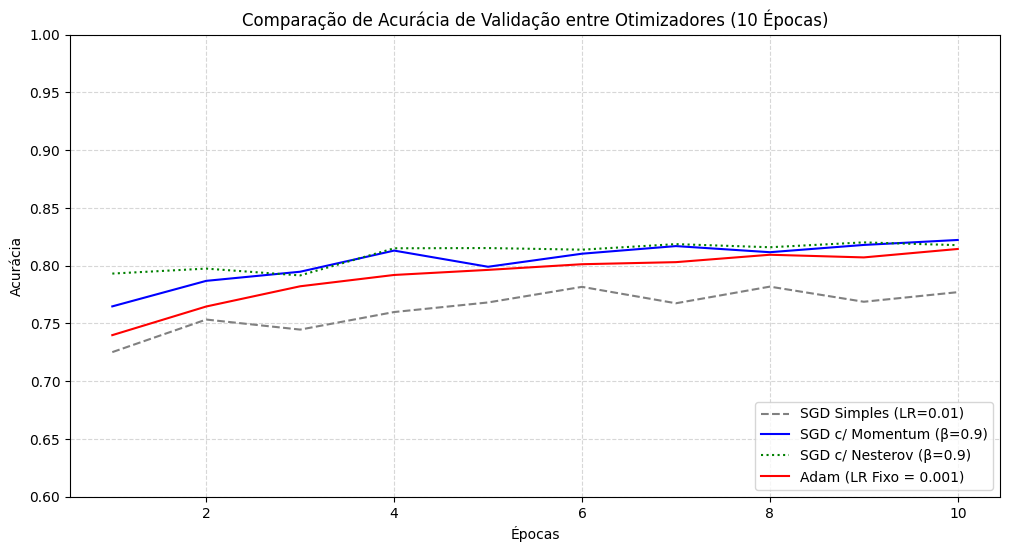


--- GRÁFICO DE GRADIENTES ADAPTADOS (TÓPICO 3) ---


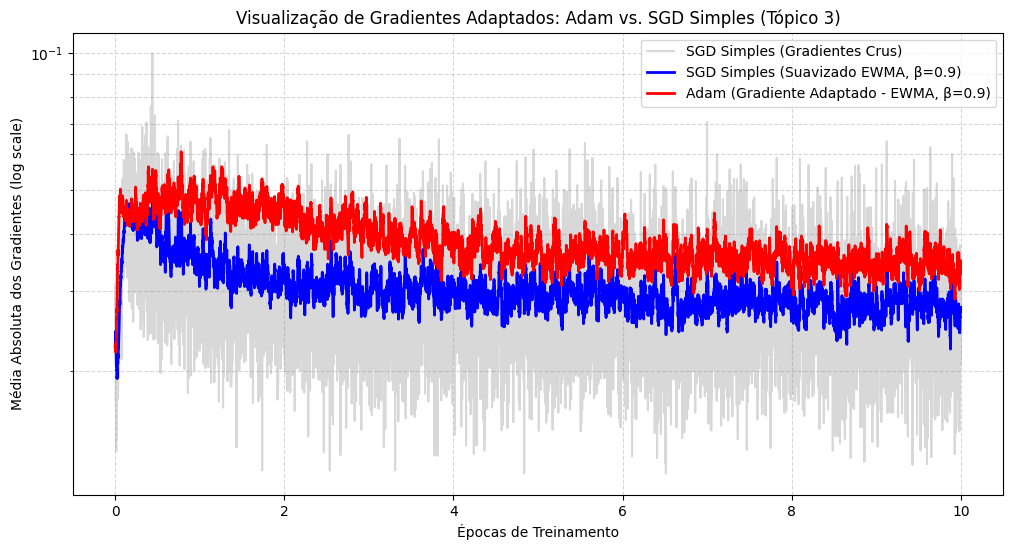


--- GRÁFICOS DE LEARNING RATE SCHEDULERS (TÓPICO 5) ---


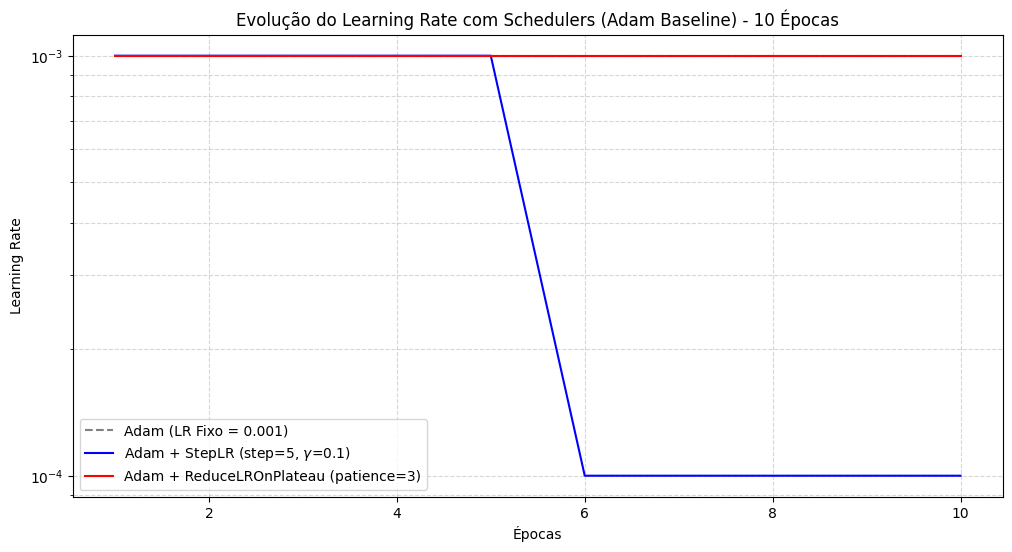

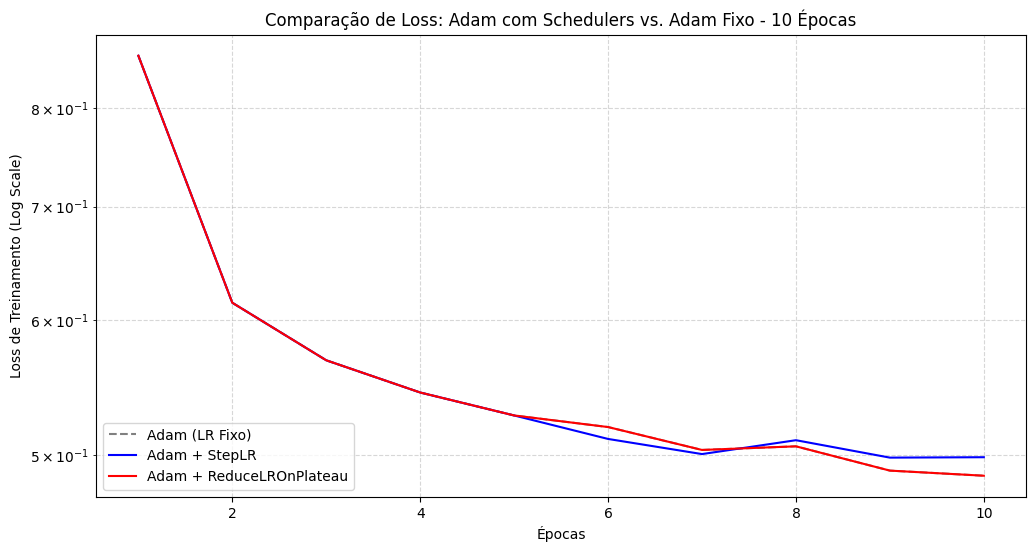

In [ ]:
# ==============================================================================
# 0. Configuração e Imports
# ==============================================================================
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Definições AJUSTADAS PARA 10 ÉPOCAS
N_EPOCHS = 10
LR_SGD = 0.01
LR_ADAM = 0.001
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Função Auxiliar para EWMA (necessária para análise do Tópico 1/3)
def ewma(data, alpha):
    """Calcula a Média Móvel Exponencialmente Ponderada (EWMA)."""
    ewma_data = [data[0]] if data else []
    for i in range(1, len(data)):
        ewma_data.append(alpha * data[i] + (1 - alpha) * ewma_data[-1])
    return ewma_data

# ==============================================================================
# 1. Classe Architecture Aprimorada (Com Coleta de Gradientes)
# ==============================================================================

class Architecture(object):
    """
    Classe aprimorada para encapsular arquitetura e treinamento,
    incluindo coleta da média absoluta de gradientes e Learning Rate por epoch.
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = DEVICE
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.total_epochs = 0
        self.all_grads = []
        self.learning_rates = []
        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()
        self.steps_per_epoch = 0

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        if train_loader:
             self.steps_per_epoch = len(train_loader)

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)

            self.optimizer.zero_grad()
            loss.backward()

            # Coleta de Gradientes Crus (Média Absoluta por mini-batch)
            avg_abs_grad = 0.0
            num_params = 0
            for param in self.model.parameters():
                if param.grad is not None:
                    avg_abs_grad += torch.abs(param.grad.detach()).mean().item()
                    num_params += 1

            if num_params > 0:
                 self.all_grads.append(avg_abs_grad / num_params)

            self.optimizer.step()

            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        data_loader = self.val_loader if validation else self.train_loader
        step_fn = self.val_step_fn if validation else self.train_step_fn
        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def _calculate_accuracy(self, data_loader):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            with torch.no_grad():
                yhat = self.model(x_batch)
                predicted = torch.argmax(yhat, dim=1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)
        return total_correct / total_samples

    def set_seed(self, seed=SEED):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def train(self, n_epochs, scheduler=None):
        self.set_seed(SEED)
        self.total_epochs = 0
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.all_grads = []
        self.learning_rates = []

        print(f"Starting training on {self.device} for {n_epochs} epochs...")
        for epoch in range(n_epochs):
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)

            with torch.no_grad():
                 val_loss = self._mini_batch(validation=True)
                 self.val_losses.append(val_loss)

            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    # ReduceLROnPlateau precisa da métrica de validação
                    scheduler.step(val_loss)
                else:
                    # StepLR e outros schedulers baseados em época/passo
                    scheduler.step()

            accuracy = self._calculate_accuracy(self.train_loader)
            self.accuracies.append(accuracy)
            val_accuracy = self._calculate_accuracy(self.val_loader)
            self.val_accuracies.append(val_accuracy)

            print(f"Epoch {self.total_epochs}/{n_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {accuracy:.4f} - Val Acc: {val_accuracy:.4f} - LR: {current_lr:.6f}")
        print("Training finished.")
        return {'losses': self.losses, 'val_losses': self.val_losses, 'val_accuracies': self.val_accuracies, 'grads': self.all_grads, 'lr': self.learning_rates, 'steps_per_epoch': self.steps_per_epoch}


# Funções auxiliares adicionais (para dataset)
def make_balanced_sampler(y):
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# Função para criar o modelo CNN (reutilizada da Unidade 2)
def create_new_cnn_model(input_size=144, output_classes=10):
    n_channels = 1
    INPUT_SIZE = input_size
    OUTPUT_CLASSES = output_classes

    torch.manual_seed(17)
    model_cnn = nn.Sequential()

    # Arquitetura LeNet-like (Unidade 2)
    model_cnn.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=5))
    model_cnn.add_module('relu1', nn.ReLU())
    model_cnn.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
    model_cnn.add_module('flatten', nn.Flatten())

    model_cnn.add_module('fc1', nn.Linear(in_features=INPUT_SIZE, out_features=10))
    model_cnn.add_module('relu2', nn.ReLU())
    model_cnn.add_module('fc2', nn.Linear(in_features=10, out_features=OUTPUT_CLASSES))

    return model_cnn.to(DEVICE)


# ==============================================================================
# 2. Preparação do Dataset e DataLoaders (Fashion-MNIST)
# ==============================================================================
print("--- 2. Preparação dos Dados (Fashion-MNIST) ---")
FASHION_MNIST_MEAN = (0.5,)
FASHION_MNIST_STD = (0.5,)
IMG_SIZE = 28
BATCH_SIZE = 64

train_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
val_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
full_train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transforms)
full_val_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=val_transforms)
y_train_tensor = full_train_dataset.targets
sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(dataset=full_train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=full_val_dataset, batch_size=BATCH_SIZE)
print(f"DataLoaders configurados. Passos por época: {len(train_loader)}")

# ==============================================================================
# 3. Experimentos de Otimização (SGD Simples, Momentum, Nesterov, Adam, Schedulers)
# ==============================================================================
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
results = {}

# Lista de otimizadores e schedulers para iteração
# StepLR e ReduceLROnPlateau configurados para 10 épocas
optimizers_config = [
    ("SGD_Simple", LR_SGD, None, False, None),
    ("SGD_Momentum_0.9", LR_SGD, 0.9, False, None),
    ("SGD_Nesterov_0.9", LR_SGD, 0.9, True, None),
    ("Adam_Fixed_LR", LR_ADAM, (0.9, 0.999), 1e-8, None),
    ("Adam_StepLR", LR_ADAM, (0.9, 0.999), 1e-8, 'StepLR'),
    ("Adam_ReduceLR", LR_ADAM, (0.9, 0.999), 1e-8, 'ReduceLR')
]

for name, lr, momentum_betas, nesterov_eps, scheduler_type in optimizers_config:
    model = create_new_cnn_model()

    # 3.1. Configuração do Otimizador
    if "Adam" in name:
         optimizer = optim.Adam(model.parameters(), lr=lr, betas=momentum_betas, eps=nesterov_eps)
    elif "SGD" in name:
         optimizer = optim.SGD(model.parameters(), lr=lr,
                               momentum=(momentum_betas if momentum_betas else 0),
                               nesterov=nesterov_eps)

    # 3.2. Configuração do Scheduler (Tópico 5)
    scheduler = None
    if scheduler_type == 'StepLR':
        # StepLR: Reduz LR para 1/10 (gamma=0.1) após 5 épocas (metade do total)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    elif scheduler_type == 'ReduceLR':
        # Corrigido: Remove o argumento 'verbose'
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # 3.3. Treinamento
    arch = Architecture(model, multi_loss_fn, optimizer)
    arch.set_loaders(train_loader, val_loader)
    print(f"\n--- Treinando com {name} ---")

    experiment_results = arch.train(N_EPOCHS, scheduler=scheduler)
    results[name] = experiment_results


# ==============================================================================
# 4. Salvamento e Preparação dos Dados para Plotagem
# ==============================================================================
print("\n--- Preparando Dados Finais para Plotagem ---")

# Cria o DataFrame consolidado
df_metrics = pd.DataFrame({
    'Epoch': list(range(1, N_EPOCHS + 1)),
    'SGD_Loss': results['SGD_Simple']['losses'],
    'Momentum_Loss': results['SGD_Momentum_0.9']['losses'],
    'Nesterov_Loss': results['SGD_Nesterov_0.9']['losses'],
    'Adam_Fixed_Loss': results['Adam_Fixed_LR']['losses'],
    'Adam_StepLR_Loss': results['Adam_StepLR']['losses'],
    'Adam_ReduceLR_Loss': results['Adam_ReduceLR']['losses'],

    'SGD_Acc': results['SGD_Simple']['val_accuracies'],
    'Momentum_Acc': results['SGD_Momentum_0.9']['val_accuracies'],
    'Nesterov_Acc': results['SGD_Nesterov_0.9']['val_accuracies'],
    'Adam_Fixed_Acc': results['Adam_Fixed_LR']['val_accuracies'],

    'Adam_Fixed_LR_Evol': results['Adam_Fixed_LR']['lr'],
    'Adam_StepLR_Evol': results['Adam_StepLR']['lr'],
    'Adam_ReduceLR_Evol': results['Adam_ReduceLR']['lr']
})

SGD_grads = results['SGD_Simple']['grads']
Adam_grads = results['Adam_Fixed_LR']['grads']
steps_per_epoch = results['Adam_Fixed_LR']['steps_per_epoch']

# ==============================================================================
# 5. Funções de Plotagem
# ==============================================================================

def plot_optimizer_metrics_comparison(metric_col, title, y_label, y_scale='linear', y_lim=None):
    """Gera o gráfico comparativo de Loss ou Accuracy para Otimizadores (Tópicos 2 e 4)."""
    plt.figure(figsize=(12, 6))

    plot_map = [
        ('SGD_Loss', 'SGD Simples (LR=0.01)', '--', 'gray', 'Loss'),
        ('Momentum_Loss', 'SGD c/ Momentum (β=0.9)', '-', 'blue', 'Loss'),
        ('Nesterov_Loss', 'SGD c/ Nesterov (β=0.9)', ':', 'green', 'Loss'),
        ('Adam_Fixed_Loss', 'Adam (LR Fixo = 0.001)', '-', 'red', 'Loss'),

        ('SGD_Acc', 'SGD Simples (LR=0.01)', '--', 'gray', 'Acc'),
        ('Momentum_Acc', 'SGD c/ Momentum (β=0.9)', '-', 'blue', 'Acc'),
        ('Nesterov_Acc', 'SGD c/ Nesterov (β=0.9)', ':', 'green', 'Acc'),
        ('Adam_Fixed_Acc', 'Adam (LR Fixo = 0.001)', '-', 'red', 'Acc')
    ]

    # Filtra o mapa para a métrica correta
    filtered_map = [item for item in plot_map if item[4] == metric_col]

    for col_name, label, linestyle, color, _ in filtered_map:
        if col_name in df_metrics.columns:
             plt.plot(df_metrics['Epoch'], df_metrics[col_name], label=label, linestyle=linestyle, color=color)

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel(y_label)
    plt.yscale(y_scale)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend(loc='lower left' if metric_col == 'Loss' else 'lower right')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

def plot_gradients_comparison_adam_sgd(title, alpha=0.1):
    """Gera o gráfico de Gradientes Adaptados (Adam) vs. Gradientes Suavizados (SGD) (Tópico 3)."""

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    steps_epochs = np.arange(len(SGD_grads)) / steps_per_epoch

    ax.plot(steps_epochs, SGD_grads, label='SGD Simples (Gradientes Crus)', alpha=0.3, c='gray')
    ax.plot(steps_epochs, ewma(SGD_grads, alpha), label=f'SGD Simples (Suavizado EWMA, β={1-alpha:.1f})', linewidth=2, c='blue')
    ax.plot(steps_epochs, ewma(Adam_grads, alpha), label=f'Adam (Gradiente Adaptado - EWMA, β={1-alpha:.1f})', linewidth=2, c='red')

    ax.set_xlabel('Épocas de Treinamento')
    ax.set_ylabel('Média Absoluta dos Gradientes (log scale)')
    ax.set_yscale('log')
    ax.set_title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

def plot_scheduler_lr_evolution(title):
    """Visualização da evolução do Learning Rate (Tópico 5)."""
    plt.figure(figsize=(12, 6))

    plt.plot(df_metrics['Epoch'], df_metrics['Adam_Fixed_LR_Evol'], label='Adam (LR Fixo = 0.001)', linestyle='--', color='gray')
    plt.plot(df_metrics['Epoch'], df_metrics['Adam_StepLR_Evol'], label='Adam + StepLR (step=5, $\gamma$=0.1)', linestyle='-', color='blue')
    plt.plot(df_metrics['Epoch'], df_metrics['Adam_ReduceLR_Evol'], label='Adam + ReduceLROnPlateau (patience=3)', linestyle='-', color='red')

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

def plot_scheduler_loss_comparison(title):
    """Comparação de desempenho (Loss) com Schedulers (Tópico 5)."""
    plt.figure(figsize=(12, 6))

    plt.plot(df_metrics['Epoch'], df_metrics['Adam_Fixed_Loss'], label='Adam (LR Fixo)', linestyle='--', color='gray')
    plt.plot(df_metrics['Epoch'], df_metrics['Adam_StepLR_Loss'], label='Adam + StepLR', linestyle='-', color='blue')
    plt.plot(df_metrics['Epoch'], df_metrics['Adam_ReduceLR_Loss'], label='Adam + ReduceLROnPlateau', linestyle='-', color='red')

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Loss de Treinamento (Log Scale)')
    plt.yscale('log')
    plt.legend(loc='lower left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

# ==============================================================================
# 6. Geração dos Gráficos Finais
# ==============================================================================

print("\n--- GRÁFICOS DE COMPARAÇÃO DE OTIMIZADORES (TÓPICOS 2 E 4) ---")
plot_optimizer_metrics_comparison(metric_col='Loss', title='Comparação de Curvas de Perda (Loss) entre Otimizadores (10 Épocas)', y_label='Loss (Log Scale)', y_scale='log')
plot_optimizer_metrics_comparison(metric_col='Acc', title='Comparação de Acurácia de Validação entre Otimizadores (10 Épocas)', y_label='Acurácia', y_lim=(0.6, 1.0))

print("\n--- GRÁFICO DE GRADIENTES ADAPTADOS (TÓPICO 3) ---")
plot_gradients_comparison_adam_sgd(title='Visualização de Gradientes Adaptados: Adam vs. SGD Simples (Tópico 3)')

print("\n--- GRÁFICOS DE LEARNING RATE SCHEDULERS (TÓPICO 5) ---")
plot_scheduler_lr_evolution(title='Evolução do Learning Rate com Schedulers (Adam Baseline) - 10 Épocas')
plot_scheduler_loss_comparison(title='Comparação de Loss: Adam com Schedulers vs. Adam Fixo - 10 Épocas')

# **LR + schedule (stepLR e LambdaLR)**

<>:269: SyntaxWarning: invalid escape sequence '\g'
<>:292: SyntaxWarning: invalid escape sequence '\g'
<>:269: SyntaxWarning: invalid escape sequence '\g'
<>:292: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1244372646.py:269: SyntaxWarning: invalid escape sequence '\g'
  (f'Adam_StepLR_{metric_col_suffix}', 'Adam + StepLR (step=3, $\gamma$=0.1)', '-', 'blue'),
/tmp/ipython-input-1244372646.py:292: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(df_metrics['Epoch'], df_metrics['Adam_StepLR_Evol'], label='Adam + StepLR (step=3, $\gamma$=0.1)', linestyle='-', color='blue')
/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


--- 2. Preparação dos Dados (Fashion-MNIST) ---


100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.99MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 64.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.9MB/s]


DataLoaders configurados.

--- Treinando com Adam_Fixed_LR ---
Starting training on cpu for 20 epochs...
Epoch 1/20 - Loss: 0.8589 - Val Loss: 0.6840 - Val Acc: 0.7399 - LR: 0.001000
Epoch 2/20 - Loss: 0.6126 - Val Loss: 0.6261 - Val Acc: 0.7678 - LR: 0.001000
Epoch 3/20 - Loss: 0.5728 - Val Loss: 0.5833 - Val Acc: 0.7824 - LR: 0.001000
Epoch 4/20 - Loss: 0.5454 - Val Loss: 0.5687 - Val Acc: 0.7916 - LR: 0.001000
Epoch 5/20 - Loss: 0.5245 - Val Loss: 0.5510 - Val Acc: 0.7948 - LR: 0.001000
Epoch 6/20 - Loss: 0.5231 - Val Loss: 0.5358 - Val Acc: 0.8010 - LR: 0.001000
Epoch 7/20 - Loss: 0.5061 - Val Loss: 0.5361 - Val Acc: 0.8045 - LR: 0.001000
Epoch 8/20 - Loss: 0.4995 - Val Loss: 0.5321 - Val Acc: 0.8086 - LR: 0.001000
Epoch 9/20 - Loss: 0.4917 - Val Loss: 0.5268 - Val Acc: 0.8112 - LR: 0.001000
Epoch 10/20 - Loss: 0.4847 - Val Loss: 0.5148 - Val Acc: 0.8115 - LR: 0.001000
Epoch 11/20 - Loss: 0.4816 - Val Loss: 0.5059 - Val Acc: 0.8167 - LR: 0.001000
Epoch 12/20 - Loss: 0.4706 - Val Lo

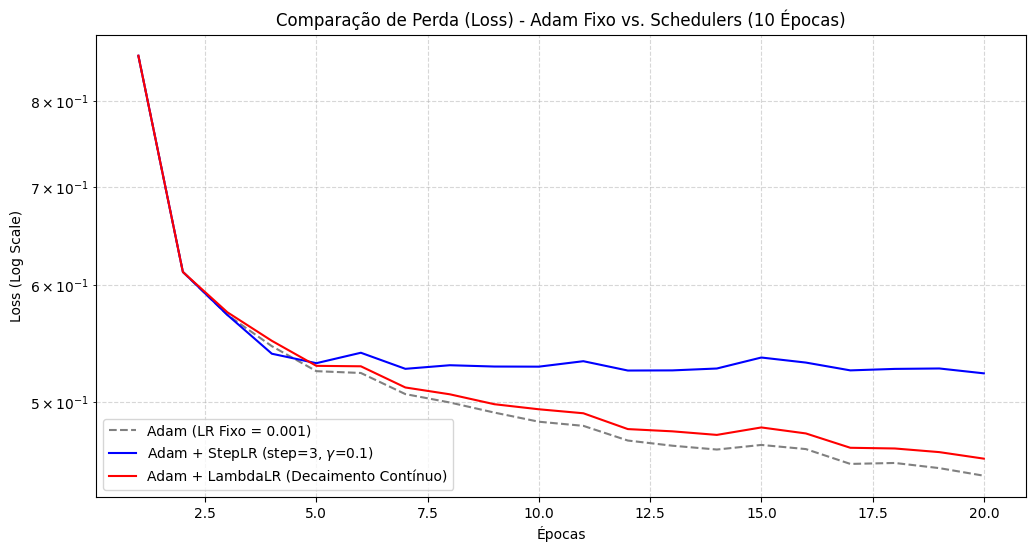

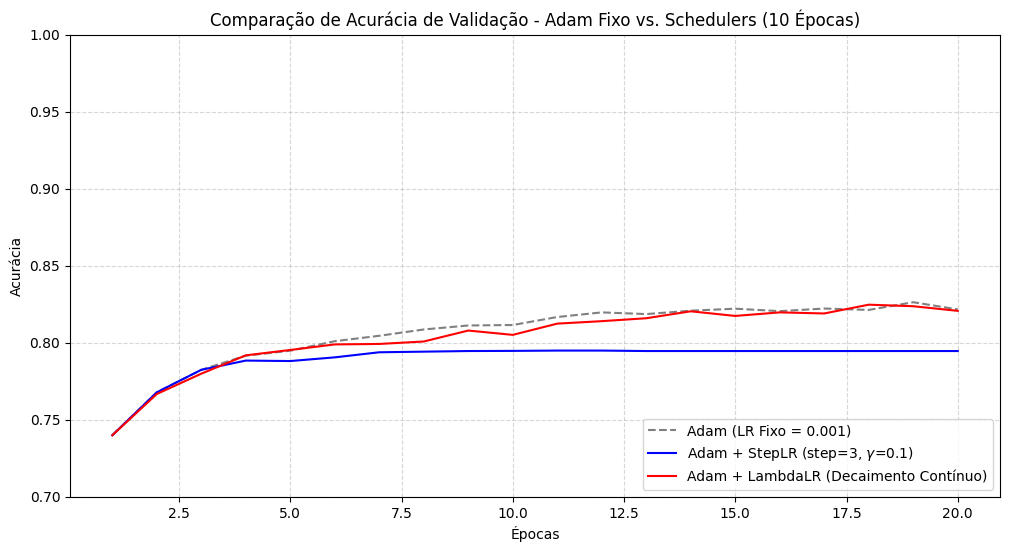


--- GRÁFICO DE LEARNING RATE SCHEDULERS (TÓPICO 5) ---


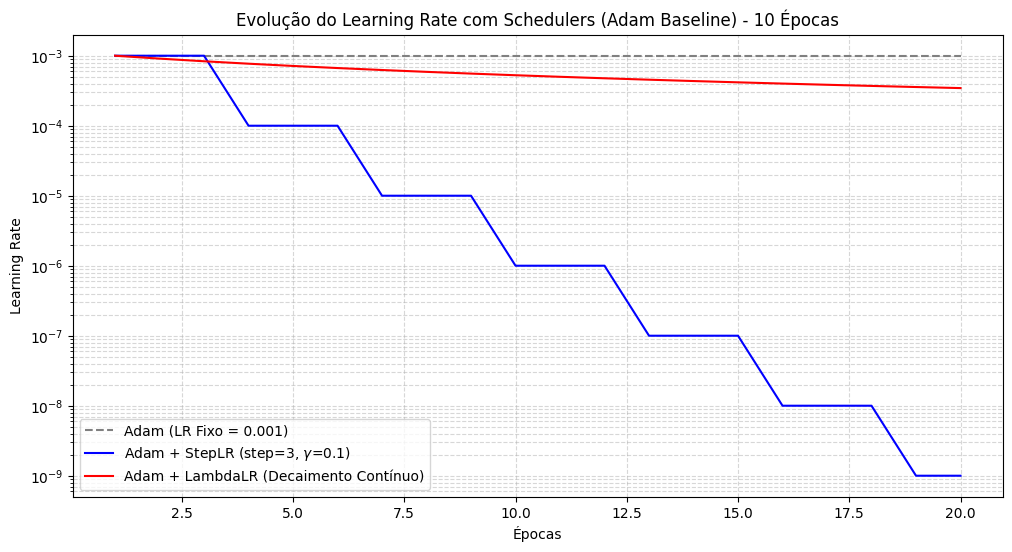

In [ ]:
# ==============================================================================
# 0. Configuração e Imports
# ==============================================================================
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import StepLR, LambdaLR

# Definições
N_EPOCHS = 20
LR_ADAM = 0.001
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==============================================================================
# 1. Classe Architecture (Apenas o necessário para Schedulers)
# ==============================================================================

class Architecture(object):
    """
    Classe para encapsular arquitetura e treinamento, focada na coleta
    de Loss, Accuracy e Learning Rate.
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = DEVICE
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.learning_rates = []

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        data_loader = self.val_loader if validation else self.train_loader
        step_fn = self._make_val_step_fn() if validation else self._make_train_step_fn()
        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def _calculate_accuracy(self, data_loader):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            with torch.no_grad():
                yhat = self.model(x_batch)
                predicted = torch.argmax(yhat, dim=1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)
        return total_correct / total_samples

    def set_seed(self, seed=SEED):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def train(self, n_epochs, scheduler=None):
        self.set_seed(SEED)

        print(f"Starting training on {self.device} for {n_epochs} epochs...")
        for epoch in range(1, n_epochs + 1):

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)

            with torch.no_grad():
                 val_loss = self._mini_batch(validation=True)
                 self.val_losses.append(val_loss)

            if scheduler:
                # StepLR e LambdaLR (baseados em época)
                scheduler.step()

            val_accuracy = self._calculate_accuracy(self.val_loader)
            self.val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch}/{n_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f} - LR: {current_lr:.6f}")
        print("Training finished.")
        # Retorna apenas os dados necessários para plotagem
        return {'losses': self.losses, 'val_losses': self.val_losses, 'val_accuracies': self.val_accuracies, 'lr': self.learning_rates}


# Funções auxiliares adicionais
def make_balanced_sampler(y):
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# Função para criar o modelo CNN (reutilizada da Unidade 2)
def create_new_cnn_model(input_size=144, output_classes=10):
    n_channels = 1
    INPUT_SIZE = input_size
    OUTPUT_CLASSES = output_classes

    torch.manual_seed(17)
    model_cnn = nn.Sequential()

    # Arquitetura LeNet-like (Unidade 2)
    model_cnn.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=5))
    model_cnn.add_module('relu1', nn.ReLU())
    model_cnn.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
    model_cnn.add_module('flatten', nn.Flatten())

    model_cnn.add_module('fc1', nn.Linear(in_features=INPUT_SIZE, out_features=10))
    model_cnn.add_module('relu2', nn.ReLU())
    model_cnn.add_module('fc2', nn.Linear(in_features=10, out_features=OUTPUT_CLASSES))

    return model_cnn.to(DEVICE)


# ==============================================================================
# 2. Preparação do Dataset e DataLoaders (Fashion-MNIST)
# ==============================================================================
print("--- 2. Preparação dos Dados (Fashion-MNIST) ---")
FASHION_MNIST_MEAN = (0.5,)
FASHION_MNIST_STD = (0.5,)
IMG_SIZE = 28
BATCH_SIZE = 64

train_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
val_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
full_train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transforms)
full_val_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=val_transforms)
y_train_tensor = full_train_dataset.targets
sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(dataset=full_train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=full_val_dataset, batch_size=BATCH_SIZE)
print(f"DataLoaders configurados.")

# ==============================================================================
# 3. Experimentos de Otimização (Foco Schedulers)
# ==============================================================================
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
results = {}

# Lista de otimizadores FOCADA em Schedulers
optimizers_config = [
    ("Adam_Fixed_LR", LR_ADAM, (0.9, 0.999), 1e-8, None), # Baseline
    ("Adam_StepLR", LR_ADAM, (0.9, 0.999), 1e-8, 'StepLR'),
    ("Adam_LambdaLR", LR_ADAM, (0.9, 0.999), 1e-8, 'LambdaLR')
]

# Definição da Função Lambda (Exemplo: Decaimento suave e contínuo)
# LR = LR_inicial * (1 / (1 + decay_rate * epoch))
decay_rate = 0.1
lambda_func = lambda epoch: 1 / (1 + decay_rate * epoch)


for name, lr, betas, eps, scheduler_type in optimizers_config:
    model = create_new_cnn_model()

    # Configuração do Otimizador Adam
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps)

    # Configuração do Scheduler
    scheduler = None
    if scheduler_type == 'StepLR':
        # StepLR: Reduz LR para 1/10 (gamma=0.1) após 3 épocas
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    elif scheduler_type == 'LambdaLR':
        # LambdaLR: Aplica a função de decaimento definida acima
        scheduler = LambdaLR(optimizer, lr_lambda=lambda_func)

    # Treinamento
    arch = Architecture(model, multi_loss_fn, optimizer)
    arch.set_loaders(train_loader, val_loader)
    print(f"\n--- Treinando com {name} ---")

    experiment_results = arch.train(N_EPOCHS, scheduler=scheduler)
    results[name] = experiment_results


# ==============================================================================
# 4. Preparação dos Dados para Plotagem
# ==============================================================================
print("\n--- Preparando Dados Finais para Plotagem ---")

df_metrics = pd.DataFrame({
    'Epoch': list(range(1, N_EPOCHS + 1)),

    'Adam_Fixed_Loss': results['Adam_Fixed_LR']['losses'],
    'Adam_StepLR_Loss': results['Adam_StepLR']['losses'],
    'Adam_LambdaLR_Loss': results['Adam_LambdaLR']['losses'],

    'Adam_Fixed_Acc': results['Adam_Fixed_LR']['val_accuracies'],
    'Adam_StepLR_Acc': results['Adam_StepLR']['val_accuracies'],
    'Adam_LambdaLR_Acc': results['Adam_LambdaLR']['val_accuracies'],

    'Adam_Fixed_LR_Evol': results['Adam_Fixed_LR']['lr'],
    'Adam_StepLR_Evol': results['Adam_StepLR']['lr'],
    'Adam_LambdaLR_Evol': results['Adam_LambdaLR']['lr']
})

# ==============================================================================
# 5. Funções de Plotagem Focadas (Tópico 5)
# ==============================================================================

def plot_scheduler_comparison_metrics(metric_type, title, y_label, y_scale='linear', y_lim=None):
    """Gera o gráfico comparativo de Loss ou Accuracy para Adam Fixo vs. Adam Schedulers."""
    plt.figure(figsize=(12, 6))

    metric_col_suffix = 'Loss' if metric_type == 'Loss' else 'Acc'

    plot_map = [
        (f'Adam_Fixed_{metric_col_suffix}', 'Adam (LR Fixo = 0.001)', '--', 'gray'),
        (f'Adam_StepLR_{metric_col_suffix}', 'Adam + StepLR (step=3, $\gamma$=0.1)', '-', 'blue'),
        (f'Adam_LambdaLR_{metric_col_suffix}', 'Adam + LambdaLR (Decaimento Contínuo)', '-', 'red')
    ]

    for col_name, label, linestyle, color in plot_map:
        if col_name in df_metrics.columns:
             plt.plot(df_metrics['Epoch'], df_metrics[col_name], label=label, linestyle=linestyle, color=color)

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel(y_label)
    plt.yscale(y_scale)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend(loc='lower left' if metric_type == 'Loss' else 'lower right')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

def plot_scheduler_lr_evolution(title):
    """Visualização da evolução do Learning Rate (Tópico 5)."""
    plt.figure(figsize=(12, 6))

    plt.plot(df_metrics['Epoch'], df_metrics['Adam_Fixed_LR_Evol'], label='Adam (LR Fixo = 0.001)', linestyle='--', color='gray')
    plt.plot(df_metrics['Epoch'], df_metrics['Adam_StepLR_Evol'], label='Adam + StepLR (step=3, $\gamma$=0.1)', linestyle='-', color='blue')
    plt.plot(df_metrics['Epoch'], df_metrics['Adam_LambdaLR_Evol'], label='Adam + LambdaLR (Decaimento Contínuo)', linestyle='-', color='red')

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

# ==============================================================================
# 6. Geração dos Gráficos Finais
# ==============================================================================

print("\n--- GRÁFICOS DE COMPARAÇÃO DE DESEMPENHO (FOCO: SCHEDULERS - TÓPICO 5) ---")
plot_scheduler_comparison_metrics(metric_type='Loss', title='Comparação de Perda (Loss) - Adam Fixo vs. Schedulers (10 Épocas)', y_label='Loss (Log Scale)', y_scale='log')
plot_scheduler_comparison_metrics(metric_type='Acc', title='Comparação de Acurácia de Validação - Adam Fixo vs. Schedulers (10 Épocas)', y_label='Acurácia', y_lim=(0.7, 1.0))

print("\n--- GRÁFICO DE LEARNING RATE SCHEDULERS (TÓPICO 5) ---")
plot_scheduler_lr_evolution(title='Evolução do Learning Rate com Schedulers (Adam Baseline) - 10 Épocas')